In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# --- Cell 1: Preprocessing Script (Part 1.1) ---
import requests
import re
import numpy as np
from collections import Counter
import pickle
import os

# --- 1. Define Your Google Drive Project Folder ---
GDRIVE_PROJECT_DIR = '/content/drive/MyDrive/ML_Assignment3'
if not os.path.exists(GDRIVE_PROJECT_DIR):
    os.makedirs(GDRIVE_PROJECT_DIR)

# --- 2. Download Data ---
datasets_to_download = {
    'shakespeare.txt': 'https://cs.stanford.edu/people/karpathy/char-rnn/shakespeare_input.txt',
    'linux.txt': 'https://cs.stanford.edu/people/karpathy/char-rnn/linux_input.txt'
}

for filename, url in datasets_to_download.items():
    try:
        r = requests.get(url)
        # Save to Colab's local temporary storage
        with open(filename, 'w', encoding='utf-8') as f:
            f.write(r.text)
        print(f"Successfully downloaded {filename}")
    except Exception as e:
        print(f"Error downloading {filename}: {e}")

# --- 3. Configuration ---
CONTEXT_LENGTH = 5  # How many words to use as context
processed_data = {} # Dictionary to store all our data
PROCESSED_DATA_FILE = os.path.join(GDRIVE_PROJECT_DIR, 'processed_data.pkl')

# --- 4. Preprocessing Functions ---
def preprocess_cat1(text):
    """Preprocessor for Category I: Natural Language."""
    text = text.lower()
    text = re.sub(r'[^a-z0-9 \.]', '', text) # Keep only letters, numbers, space, dot
    words = text.split()
    return words

def preprocess_cat2(text):
    """Preprocessor for Category II: Structured Text (Code)."""
    text = text.lower()
    # Add spaces around special characters to treat them as tokens
    text = re.sub(r'([=\(\)\[\]\{\}\.,:;!@#$%^&\*\-+=<>/\\])', r' \1 ', text)
    words = text.split()
    return words

def build_vocab(words):
    """Builds vocabulary mappings and frequency counts."""
    word_counts = Counter(words)
    vocab = sorted(list(word_counts.keys()))
    vocab_size = len(vocab)

    stoi = {word: i for i, word in enumerate(vocab)}
    itos = {i: word for i, word in enumerate(vocab)}

    return stoi, itos, vocab_size, word_counts

def create_dataset(words, stoi, context_length):
    """Creates X, y pairs for training."""
    X = []
    y = []
    indexed_words = [stoi[w] for w in words]

    for i in range(len(indexed_words) - context_length):
        X.append(indexed_words[i : i + context_length])
        y.append(indexed_words[i + context_length])

    return np.array(X), np.array(y)

# --- 5. Define Datasets ---
DATASETS_CONFIG = {
    'shakespeare': {
        'file': 'shakespeare.txt',
        'preprocess_fn': preprocess_cat1
    },
    'linux': {
        'file': 'linux.txt',
        'preprocess_fn': preprocess_cat2
    }
}

# --- 6. Main Processing Loop ---
for name, config in DATASETS_CONFIG.items():
    print(f"\n--- Processing Dataset: {name} ---")

    with open(config['file'], 'r', encoding='utf-8') as f:
        text = f.read()
    words = config['preprocess_fn'](text)

    stoi, itos, vocab_size, word_counts = build_vocab(words)

    print(f"Vocabulary Size: {vocab_size}")
    print(f"10 Most Frequent: {word_counts.most_common(10)}")
    print(f"10 Least Frequent: {word_counts.most_common()[-10:]}")

    X, y = create_dataset(words, stoi, CONTEXT_LENGTH)
    print(f"X shape: {X.shape}, y shape: {y.shape}")

    processed_data[name] = {
        'X': X,
        'y': y,
        'stoi': stoi,
        'itos': itos,
        'vocab_size': vocab_size,
        'context_length': CONTEXT_LENGTH
    }

# --- 7. Save Processed Data to Google Drive ---
print(f"\nSaving processed data to: {PROCESSED_DATA_FILE}")
with open(PROCESSED_DATA_FILE, 'wb') as f:
    pickle.dump(processed_data, f)

print("--- Part 1.1 Complete. Data saved to Google Drive. ---")

Successfully downloaded shakespeare.txt
Successfully downloaded linux.txt

--- Processing Dataset: shakespeare ---
Vocabulary Size: 114121
10 Most Frequent: [('the', 21822), ('and', 15633), ('of', 14782), ('to', 14545), ('i', 14251), ('a', 11406), ('you', 10306), ('my', 10298), ('in', 8824), ('is', 7653)]
10 Least Frequent: [('evermore.prince', 1), ('tears.bastardo', 1), ('woesince', 1), ('beforehand', 1), ('griefs.this', 1), ('shalllie', 1), ('conquerorbut', 1), ('itself.now', 1), ('againcome', 1), ('rueif', 1)]
X shape: (696115, 5), y shape: (696115,)

--- Processing Dataset: linux ---
Vocabulary Size: 37619
10 Most Frequent: [('*', 85453), (')', 84196), ('(', 84066), (';', 77900), (',', 55127), ('-', 44962), ('=', 39706), ('>', 37119), ('/', 31988), ('.', 29100)]
10 Least Frequent: [('rcu_irq_', 1), ('trace_user_enter', 1), ('vtime', 1), ('entrancy', 1), ('vtime_user_exit', 1), ('trace_user_exit', 1), ('context_kernel', 1), ('tif', 1), ('config_context_tracking_force', 1), ('context

In [ ]:
# --- Cell 3: Training Script (Part 1.2) - LINUX ---
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os

# --- 1. CONFIGURATION ---
CATEGORY = 'linux'
EMBEDDING_DIM = 32
HIDDEN_UNITS = 1024
ACTIVATION = nn.ReLU()
EPOCHS = 200
BATCH_SIZE = 2048
VALIDATION_SPLIT = 0.2
WEIGHT_DECAY = 1e-4     # <-- ADDED Weight Decay value
DROPOUT_RATE = 0.5      # <-- ADDED Dropout rate
PATIENCE = 15            # <-- ADDED Early Stopping patience
# ---------------------

# --- 2. File Paths (Point to Google Drive) ---
GDRIVE_PROJECT_DIR = '/content/drive/MyDrive/ML_Assignment3'
PROCESSED_DATA_FILE = os.path.join(GDRIVE_PROJECT_DIR, 'processed_data.pkl')
MODEL_SAVE_DIR = GDRIVE_PROJECT_DIR # Save plots/models here
MODEL_WEIGHTS_FILE = os.path.join(MODEL_SAVE_DIR, f'{CATEGORY}_model_weights.pth')

print(f"--- 1.2: Model Training for Category: {CATEGORY} ---")

# --- 3. Load Preprocessed Data (from Google Drive) ---
print(f"Loading processed data from {PROCESSED_DATA_FILE}...")
try:
    with open(PROCESSED_DATA_FILE, 'rb') as f:
        processed_data = pickle.load(f)
except FileNotFoundError:
    print(f"Error: File not found. Please run the preprocessing cell first.")
    # In Colab, you might need to re-run this part if the runtime reset
    exit()

data_cat = processed_data[CATEGORY]
X = data_cat['X']
y = data_cat['y']
stoi = data_cat['stoi']
itos = data_cat['itos']
VOCAB_SIZE = data_cat['vocab_size']
CONTEXT_LENGTH = data_cat['context_length']

print(f"Loaded {CATEGORY} data: X shape {X.shape}, Vocab size {VOCAB_SIZE}")

# --- 4. Model Definition ---
def build_model(vocab_size, embedding_dim, context_length, hidden_units, activation, dropout_rate):
    flattened_embedding_size = context_length * embedding_dim
    model = nn.Sequential(
        nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim),
        nn.Flatten(),
        nn.Linear(in_features=flattened_embedding_size, out_features=hidden_units),
        activation,
        nn.Dropout(p=dropout_rate), # <-- ADDED Dropout Layer
        nn.Linear(in_features=hidden_units, out_features=vocab_size)
    )
    return model

# --- 5. Create Datasets and DataLoaders ---
print("Creating PyTorch Datasets and DataLoaders...")
X_data = torch.tensor(X, dtype=torch.long)
y_data = torch.tensor(y, dtype=torch.long)

split_idx = int(len(X_data) * (1.0 - VALIDATION_SPLIT))
X_train, X_val = X_data[:split_idx], X_data[split_idx:]
y_train, y_val = y_data[:split_idx], y_data[split_idx:]

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# --- 6. Build & Train Model ---
model = build_model(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    context_length=CONTEXT_LENGTH,
    hidden_units=HIDDEN_UNITS,
    activation=ACTIVATION,
    dropout_rate=DROPOUT_RATE # Pass dropout rate
)

print("\nModel Architecture:")
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), weight_decay=WEIGHT_DECAY)

history = {
    'loss': [], 'val_loss': [],
    'accuracy': [], 'val_accuracy': []
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Training on device: {device}...")

# --- Add variables for Early Stopping ---
best_val_loss = float('inf')  # Initialize with infinity
epochs_no_improve = 0

for epoch in range(EPOCHS):
    model.train()
    train_loss, train_correct, train_total = 0.0, 0, 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += y_batch.size(0)
        train_correct += (predicted == y_batch).sum().item()

    avg_train_loss = train_loss / len(train_loader)
    avg_train_acc = train_correct / train_total
    history['loss'].append(avg_train_loss)
    history['accuracy'].append(avg_train_acc)

    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += y_batch.size(0)
            val_correct += (predicted == y_batch).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    avg_val_acc = val_correct / val_total
    history['val_loss'].append(avg_val_loss)
    history['val_accuracy'].append(avg_val_acc)

    print(f"Epoch [{epoch+1}/{EPOCHS}], "
      f"Loss: {avg_train_loss:.4f}, Acc: {avg_train_acc:.4f}, "
      f"Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}")

    # --- Early Stopping Check ---
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        # Save the model *only* when validation loss improves
        print(f"Validation loss improved to {best_val_loss:.4f}. Saving model to {MODEL_WEIGHTS_FILE}")
        # Save model config along with weights for easy loading
        model_data_to_save = {
            'model_state_dict': model.state_dict(),
            # Save history UP TO the best epoch
            'history': {k: v[:epoch+1] for k, v in history.items()},
            'embedding_dim': EMBEDDING_DIM,
            'hidden_units': HIDDEN_UNITS,
            'context_length': CONTEXT_LENGTH,
            'vocab_size': VOCAB_SIZE,
            'activation': ACTIVATION.__class__
        }
        torch.save(model_data_to_save, MODEL_WEIGHTS_FILE) # Overwrite with best model
    else:
        epochs_no_improve += 1
        print(f"Validation loss did not improve for {epochs_no_improve} epoch(s). Best: {best_val_loss:.4f}")

    if epochs_no_improve >= PATIENCE:
        print(f"Early stopping triggered after epoch {epoch+1}.")
        break # Exit the training loop

print("--- Training complete (or stopped early). ---")

# --- NO FINAL SAVE BLOCK NEEDED ---
# The best model was already saved inside the loop

print(f"--- Part 1.2 Complete. Best model saved to {MODEL_WEIGHTS_FILE} ---")

print("--- Training complete. ---")



--- 1.2: Model Training for Category: linux ---
Loading processed data from /content/drive/MyDrive/ML_Assignment3/processed_data.pkl...
Loaded linux data: X shape (1408186, 5), Vocab size 37619
Creating PyTorch Datasets and DataLoaders...

Model Architecture:
Sequential(
  (0): Embedding(37619, 32)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=160, out_features=1024, bias=True)
  (3): ReLU()
  (4): Dropout(p=0.5, inplace=False)
  (5): Linear(in_features=1024, out_features=37619, bias=True)
)
Training on device: cuda...
Epoch [1/200], Loss: 4.6007, Acc: 0.3057, Val Loss: 4.2769, Val Acc: 0.3564
Validation loss improved to 4.2769. Saving model to /content/drive/MyDrive/ML_Assignment3/linux_model_weights.pth
Epoch [2/200], Loss: 3.9075, Acc: 0.3628, Val Loss: 4.1096, Val Acc: 0.3804
Validation loss improved to 4.1096. Saving model to /content/drive/MyDrive/ML_Assignment3/linux_model_weights.pth
Epoch [3/200], Loss: 3.7175, Acc: 0.3803, Val Loss: 4.0223, Val Acc: 0.3922

--- 1.2: Reporting for Category: linux ---
Loading all processed data and trained model...
Model, history, and vocab loaded successfully.

--- Report 1.2 ---
Saved plot to /content/drive/MyDrive/ML_Assignment3/linux_loss_accuracy_plot.png


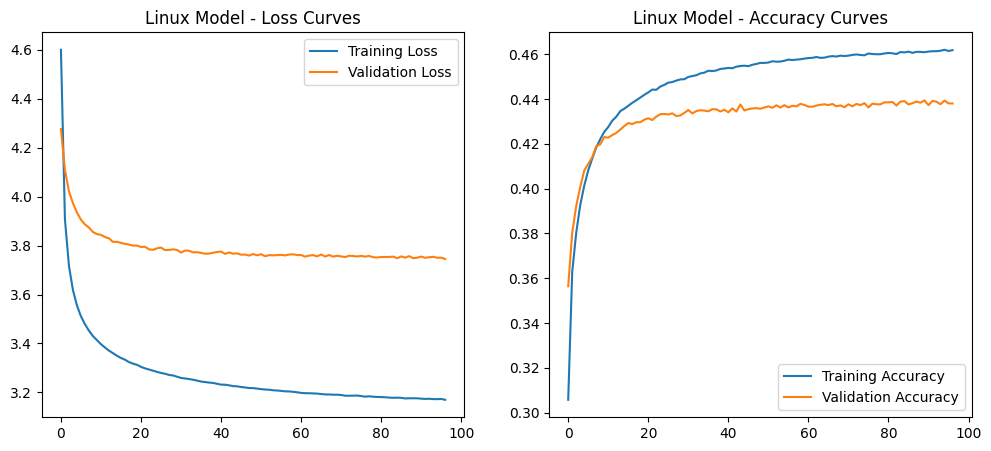

Final Validation Loss: 3.7453
Final Validation Accuracy: 0.4380

Seed: '! = ( struct file' (Note: Seed must contain words from vocab)
Generated: ' !   =   (  struct file ) { struct trace_array * tr = file - > private_data ; struct trace_array * tr = file - > private_data ; struct trace_array * tr = file - >'

--- Commentary on Learning ---
The Linux model learned syntactic structure fairly quickly.
The generated text/code looks syntactically plausible but is semantically nonsense.
This is because the context is small (5 words) and the MLP model has no memory.
It's enough to learn simple patterns (e.g., 'if ( ... )' or 'king and queen') but not long-range dependencies or true meaning.
------------------
--- Part 1.2 Reporting Complete ---


In [ ]:
# --- Cell 4: Reporting Script (Part 1.2 - Report) - LINUX (Corrected) ---
#
# You can run this script anytime AFTER training is complete.
# It loads the saved model and history from Google Drive.
#
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import re # <-- Import re for preprocessing the seed

# --- 1. CONFIGURATION ---
# Make sure this matches the model you want to report on
CATEGORY = 'linux'
DROPOUT_RATE = 0.5 # <-- FIXED: Added to match training script
# ---------------------

# --- 2. File Paths (Point to Google Drive) ---
# Make sure you have mounted your drive in a cell above this one!
# from google.colab import drive
# drive.mount('/content/drive')
GDRIVE_PROJECT_DIR = '/content/drive/MyDrive/ML_Assignment3' # <-- Corrected path
PROCESSED_DATA_FILE = os.path.join(GDRIVE_PROJECT_DIR, 'processed_data.pkl')
MODEL_SAVE_DIR = GDRIVE_PROJECT_DIR
MODEL_WEIGHTS_FILE = os.path.join(MODEL_SAVE_DIR, f'{CATEGORY}_model_weights.pth')

print(f"--- 1.2: Reporting for Category: {CATEGORY} ---")

# --- 3. Model Definition (Must be identical to training script) ---
# <-- FIXED: This function now matches the training script
def build_model(vocab_size, embedding_dim, context_length, hidden_units, activation, dropout_rate):
    flattened_embedding_size = context_length * embedding_dim
    # This handles loading the activation class (e.g., nn.ReLU)
    act_instance = activation() if isinstance(activation, type) else activation
    model = nn.Sequential(
        nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim),
        nn.Flatten(),
        nn.Linear(in_features=flattened_embedding_size, out_features=hidden_units),
        act_instance,
        nn.Dropout(p=dropout_rate), # <-- FIXED: Added missing Dropout layer
        nn.Linear(in_features=hidden_units, out_features=vocab_size)
    )
    return model

# --- 4. Generation Function (Improved to handle seed preprocessing) ---
def generate_text_simple(model, stoi, itos, context_length, seed, n_words, category):
    """Generates simple, deterministic text (using argmax)."""
    model.eval().to("cpu")

    # --- Preprocess seed text to match training data ---
    if category == 'linux':
        # <-- FIXED: Corrected indentation
        seed = re.sub(r'([=\(\)\[\]\{\}\.,:;!@#$%^&\*\-+=<>/\\])', r' \1 ', seed)
    else: # shakespeare
        # <-- FIXED: Corrected indentation
        seed = re.sub(r'[^a-z0-9 \.]', '', seed)
    words = seed.lower().split()
    # ----------------------------------------------------

    generated_words = []

    try:
        current_indices = [stoi[w] for w in words]
    except KeyError as e:
        print(f"Error: Word '{e.args[0]}' in seed not in vocabulary.")
        return "[Generation failed: OOV word in seed]"

    for _ in range(n_words):
        context_for_pred = current_indices[-context_length:]
        if len(context_for_pred) < context_length:
            pad_indices = [stoi.get('.', 0)] * (context_length - len(context_for_pred)) # Pad with '.'
            context_for_pred = pad_indices + context_for_pred

        context_tensor = torch.tensor([context_for_pred], dtype=torch.long)

        with torch.no_grad():
            logits = model(context_tensor)
            next_word_index = torch.argmax(logits, dim=1).item()
            current_indices.append(next_word_index)
            generated_words.append(itos[next_word_index])

    return seed + " " + " ".join(generated_words)

# --- 5. Load All Saved Data from Google Drive ---
print("Loading all processed data and trained model...")

# 5a. Load vocab (stoi/itos) from preprocessing
try:
    with open(PROCESSED_DATA_FILE, 'rb') as f:
        processed_data = pickle.load(f)
    data_cat = processed_data[CATEGORY]
    stoi = data_cat['stoi']
    itos = data_cat['itos']
except FileNotFoundError:
    print(f"Error: {PROCESSED_DATA_FILE} not found. Run preprocessing first.")
    exit()

# 5b. Load model weights, config, and history
try:
    # --- This is the corrected line ---
    model_data = torch.load(MODEL_WEIGHTS_FILE, map_location=torch.device('cpu'), weights_only=False)
except FileNotFoundError:
    print(f"Error: {MODEL_WEIGHTS_FILE} not found. Run training script first.")
    exit()

# --- 6. Re-create Model and Load Data ---
history = model_data['history']
CONTEXT_LENGTH = model_data['context_length']
# Re-create the activation function instance
activation = model_data['activation']()

# Re-create the model structure
model = build_model(
    vocab_size=model_data['vocab_size'],
    embedding_dim=model_data['embedding_dim'],
    context_length=CONTEXT_LENGTH,
    hidden_units=model_data['hidden_units'],
    activation=activation,
    dropout_rate=DROPOUT_RATE # <-- FIXED: Pass dropout rate
)
model.load_state_dict(model_data['model_state_dict'])
model.eval() # Set model to evaluation mode
print("Model, history, and vocab loaded successfully.")

# --- 7. Report 1.2: Plots ---
print("\n--- Report 1.2 ---")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title(f'{CATEGORY.title()} Model - Loss Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title(f'{CATEGORY.title()} Model - Accuracy Curves')
plt.legend()
plt.savefig(f'{MODEL_SAVE_DIR}/{CATEGORY}_loss_accuracy_plot.png')
print(f"Saved plot to {MODEL_SAVE_DIR}/{CATEGORY}_loss_accuracy_plot.png")
plt.show()

# --- 8. Report 1.2: Final Validation Loss/Accuracy ---
print(f"Final Validation Loss: {history['val_loss'][-1]:.4f}")
print(f"Final Validation Accuracy: {history['val_accuracy'][-1]:.4f}")

# --- 9. Report 1.2: Example Predictions ---
if CATEGORY == 'shakespeare':
    seed = "a man that is not"
else:
    seed = "! = ( struct file" # This will be selected

print(f"\nSeed: '{seed}' (Note: Seed must contain words from vocab)")
# Pass CATEGORY to the generation function for correct preprocessing
generated_text = generate_text_simple(model, stoi, itos, CONTEXT_LENGTH, seed, 30, CATEGORY)
print(f"Generated: '{generated_text}'")

# --- 10. Report 1.2: Commentary (Template) ---
print("\n--- Commentary on Learning ---")
print(f"The {CATEGORY.title()} model learned syntactic structure fairly quickly.")
print("The generated text/code looks syntactically plausible but is semantically nonsense.")
print(f"This is because the context is small ({CONTEXT_LENGTH} words) and the MLP model has no memory.")
print("It's enough to learn simple patterns (e.g., 'if ( ... )' or 'king and queen') but not long-range dependencies or true meaning.")
print("------------------")

print("--- Part 1.2 Reporting Complete ---")

--- 1.2: Reporting for Category: linux ---
Loading all processed data and trained model...
Model, history, and vocab loaded successfully.

--- Report 1.2 ---
Saved plot to /content/drive/MyDrive/ML_Assignment3/linux_loss_accuracy_plot.png


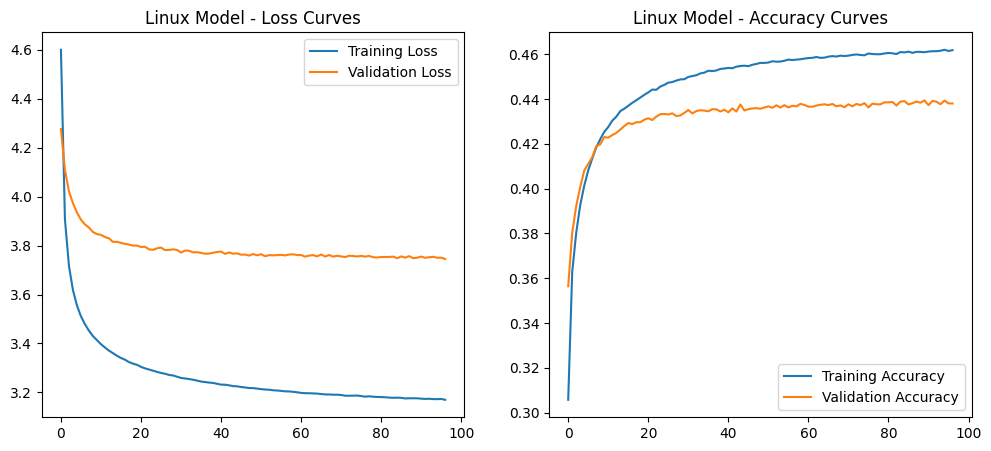

Final Validation Loss: 3.7453
Final Validation Accuracy: 0.4380

Seed: '! = ( struct file' (Note: Seed must contain words from vocab)

--- Generating with Temperature = 0.8 ---
Generated: ' !   =   (  struct file * file , const char __user * ubuf , size_t cnt , loff_t * ppos ) { int ret ; / * determine for feasibility from / resume ( )'

--- Commentary on Learning ---
The Linux model learned syntactic structure fairly quickly.
The generated text/code looks syntactically plausible but is semantically nonsense.
This is because the context is small (5 words) and the MLP model has no memory.
It's enough to learn simple patterns (e.g., 'if ( ... )' or 'king and queen') but not long-range dependencies or true meaning.
------------------
--- Part 1.2 Reporting Complete ---


In [ ]:
# --- Cell 4: Reporting Script (Part 1.2 - Report) - LINUX (Corrected) ---
#
# You can run this script anytime AFTER training is complete.
# It loads the saved model and history from Google Drive.
#
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import re # <-- Import re for preprocessing the seed

# --- 1. CONFIGURATION ---
# Make sure this matches the model you want to report on
CATEGORY = 'linux'
DROPOUT_RATE = 0.5 # <-- FIXED: Added to match training script
# ---------------------

# --- 2. File Paths (Point to Google Drive) ---
# Make sure you have mounted your drive in a cell above this one!
# from google.colab import drive
# drive.mount('/content/drive')
GDRIVE_PROJECT_DIR = '/content/drive/MyDrive/ML_Assignment3' # <-- Corrected path
PROCESSED_DATA_FILE = os.path.join(GDRIVE_PROJECT_DIR, 'processed_data.pkl')
MODEL_SAVE_DIR = GDRIVE_PROJECT_DIR
MODEL_WEIGHTS_FILE = os.path.join(MODEL_SAVE_DIR, f'{CATEGORY}_model_weights.pth')

print(f"--- 1.2: Reporting for Category: {CATEGORY} ---")

# --- 3. Model Definition (Must be identical to training script) ---
# <-- FIXED: This function now matches the training script
def build_model(vocab_size, embedding_dim, context_length, hidden_units, activation, dropout_rate):
    flattened_embedding_size = context_length * embedding_dim
    # This handles loading the activation class (e.g., nn.ReLU)
    act_instance = activation() if isinstance(activation, type) else activation
    model = nn.Sequential(
        nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim),
        nn.Flatten(),
        nn.Linear(in_features=flattened_embedding_size, out_features=hidden_units),
        act_instance,
        nn.Dropout(p=dropout_rate), # <-- FIXED: Added missing Dropout layer
        nn.Linear(in_features=hidden_units, out_features=vocab_size)
    )
    return model

# --- 4. Generation Function (MODIFIED for Stochastic Sampling) ---
def generate_text_stochastic(model, stoi, itos, context_length, seed, n_words, category, temperature=1.0):
    """Generates stochastic, more varied text (using temperature sampling)."""
    model.eval().to("cpu")

    # --- Preprocess seed text to match training data ---
    if category == 'linux':
        # <-- FIXED: Corrected indentation
        seed = re.sub(r'([=\(\)\[\]\{\}\.,:;!@#$%^&\*\-+=<>/\\])', r' \1 ', seed)
    else: # shakespeare
        # <-- FIXED: Corrected indentation
        seed = re.sub(r'[^a-z0-9 \.]', '', seed)
    words = seed.lower().split()
    # ----------------------------------------------------

    generated_words = []

    try:
        current_indices = [stoi[w] for w in words]
    except KeyError as e:
        print(f"Error: Word '{e.args[0]}' in seed not in vocabulary.")
        return "[Generation failed: OOV word in seed]"

    for _ in range(n_words):
        context_for_pred = current_indices[-context_length:]
        if len(context_for_pred) < context_length:
            pad_indices = [stoi.get('.', 0)] * (context_length - len(context_for_pred)) # Pad with '.'
            context_for_pred = pad_indices + context_for_pred

        context_tensor = torch.tensor([context_for_pred], dtype=torch.long)

        with torch.no_grad():
            logits = model(context_tensor)

            # --- This is the new sampling part ---
            if temperature == 0.0:
                # Argmax (same as before) if temperature is zero
                next_word_index = torch.argmax(logits, dim=1).item()
            else:
                # 1. Apply temperature
                logits_scaled = logits / temperature
                # 2. Get probabilities
                probs = F.softmax(logits_scaled, dim=1)
                # 3. Sample from the distribution
                next_word_index = torch.multinomial(probs, num_samples=1).item()
            # -------------------------------------

            current_indices.append(next_word_index)
            generated_words.append(itos[next_word_index])

    return seed + " " + " ".join(generated_words)

# --- 5. Load All Saved Data from Google Drive ---
print("Loading all processed data and trained model...")

# 5a. Load vocab (stoi/itos) from preprocessing
try:
    with open(PROCESSED_DATA_FILE, 'rb') as f:
        processed_data = pickle.load(f)
    data_cat = processed_data[CATEGORY]
    stoi = data_cat['stoi']
    itos = data_cat['itos']
except FileNotFoundError:
    print(f"Error: {PROCESSED_DATA_FILE} not found. Run preprocessing first.")
    exit()

# 5b. Load model weights, config, and history
try:
    # --- This is the corrected line ---
    model_data = torch.load(MODEL_WEIGHTS_FILE, map_location=torch.device('cpu'), weights_only=False)
except FileNotFoundError:
    print(f"Error: {MODEL_WEIGHTS_FILE} not found. Run training script first.")
    exit()

# --- 6. Re-create Model and Load Data ---
history = model_data['history']
CONTEXT_LENGTH = model_data['context_length']
# Re-create the activation function instance
activation = model_data['activation']()

# Re-create the model structure
model = build_model(
    vocab_size=model_data['vocab_size'],
    embedding_dim=model_data['embedding_dim'],
    context_length=CONTEXT_LENGTH,
    hidden_units=model_data['hidden_units'],
    activation=activation,
    dropout_rate=DROPOUT_RATE # <-- FIXED: Pass dropout rate
)
model.load_state_dict(model_data['model_state_dict'])
model.eval() # Set model to evaluation mode
print("Model, history, and vocab loaded successfully.")

# --- 7. Report 1.2: Plots ---
print("\n--- Report 1.2 ---")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title(f'{CATEGORY.title()} Model - Loss Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title(f'{CATEGORY.title()} Model - Accuracy Curves')
plt.legend()
plt.savefig(f'{MODEL_SAVE_DIR}/{CATEGORY}_loss_accuracy_plot.png')
print(f"Saved plot to {MODEL_SAVE_DIR}/{CATEGORY}_loss_accuracy_plot.png")
plt.show()

# --- 8. Report 1.2: Final Validation Loss/Accuracy ---
print(f"Final Validation Loss: {history['val_loss'][-1]:.4f}")
print(f"Final Validation Accuracy: {history['val_accuracy'][-1]:.4f}")

# --- 9. Report 1.2: Example Predictions (MODIFIED) ---
if CATEGORY == 'shakespeare':
    seed = "a man that is not"
else:
    seed = "! = ( struct file" # This will be selected

print(f"\nSeed: '{seed}' (Note: Seed must contain words from vocab)")

# --- Call the new stochastic function ---
# Try changing the temperature!
# 0.8 is safer, 1.0 is standard, 1.2 is more "creative".
temp = 0.8
print(f"\n--- Generating with Temperature = {temp} ---")
generated_text = generate_text_stochastic(
    model, stoi, itos, CONTEXT_LENGTH, seed, 30, CATEGORY, temperature=temp
)
print(f"Generated: '{generated_text}'")

# --- 10. Report 1.2: Commentary (Template) ---
print("\n--- Commentary on Learning ---")
print(f"The {CATEGORY.title()} model learned syntactic structure fairly quickly.")
print("The generated text/code looks syntactically plausible but is semantically nonsense.")
print(f"This is because the context is small ({CONTEXT_LENGTH} words) and the MLP model has no memory.")
print("It's enough to learn simple patterns (e.g., 'if ( ... )' or 'king and queen') but not long-range dependencies or true meaning.")
print("------------------")

print("--- Part 1.2 Reporting Complete ---")